In [166]:
import pandas as pd
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns

# Load and Organize Data

In [107]:
cannabis_df = pd.read_csv("cannabis_full.csv")
cannabis_df.head()

,Strain,Type,Rating,Effects,Flavor,Creative,Energetic,Tingly,Euphoric,Relaxed,...,Ammonia,Minty,Tree,Fruit,Butter,Pineapple,Tar,Rose,Plum,Pear
0,100-Og,hybrid,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,98-White-Widow,hybrid,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,13-Dawgs,hybrid,4.2,"Tingly,Creative,Hungry,Relaxed,Uplifted","Apricot,Citrus,Grapefruit",1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,24K-Gold,hybrid,4.6,"Happy,Relaxed,Euphoric,Uplifted,Talkative","Citrus,Earthy,Orange",0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [108]:
def split_dataset(data, target_column, test_ratio):
    np.random.seed(42)
    num_test = int(len(data) * test_ratio)
    
    shuffled_indices = np.random.permutation(len(data))
    test_indices = shuffled_indices[:num_test]
    train_indices = shuffled_indices[num_test:]

    train_df = data.iloc[train_indices]
    test_df = data.iloc[test_indices]

    X_train = train_df.drop(target_column, axis=1)
    y_train = train_df[target_column]

    X_test = test_df.drop(target_column, axis=1)
    y_test = test_df[target_column]

    return X_train, y_train, X_test, y_test

In [109]:
c_df = cannabis_df.dropna()
c_df = c_df[c_df["Type"].isin(["sativa", "indica"])]
c_df["Type_is_sativa"] = np.where(c_df["Type"] == "sativa", 1, 0)
c_df = c_df.drop(["Strain", "Effects", "Flavor", "Type"], axis=1)

X_train, y_train, X_test, y_test = split_dataset(c_df, target_column="Type_is_sativa", test_ratio=0.2)
X_train["intercept"] = 1
X_test["intercept"] = 1

In [110]:
len(X_train.columns)

66

# Implementation

## NN Functions

### Numpy Version

In [111]:
def precision(y, yhat):
    true_positives = np.sum((y == 1) & (yhat == 1))
    predicted_positives = np.sum(yhat == 1)
    return true_positives / predicted_positives

def recall(y, yhat):
    true_positives = np.sum((y == 1) & (yhat == 1))
    actual_positives = np.sum(y == 1)
    return true_positives / actual_positives

def f1_score(precision, recall):
    return 2 * precision * recall / (precision + recall)

In [112]:
# Activation Functions

def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softplus(x):
    return np.logaddexp(x, 0) # -> np.log(1 + np.exp(x))

In [113]:
# Loss Functions

def squared_error(y, yhat):
    n = len(y)
    l = 1 / n * np.power(np.sum(yhat - y), 2)
    return l

def svc_hinge_loss(y, yhat):
    n = len(y)
    l = 1 / n * np.sum(np.where(y * yhat) > 1, y * yhat, 0)
    return l

In [114]:
# Gradient Functions

def sigmoid_grad(z):
    left = np.power(1 / (1 + np.exp(-z)), 2)
    right = -np.exp(-z)
    return left * right

def relu_grad(u):
    return np.where(u > 0, 1, 0)

def softplus_grad(n):
    clipped_n = np.clip(n, -500, 500)
    num = np.exp(clipped_n)
    den = np.exp(clipped_n) + 1
    return num / den

def squared_error_grad(y, yhat):
    n = len(y)
    dl = 2 / n * np.sum(yhat - y)
    return dl

def svc_hinge_grad(y, yhat):
    n = len(y)
    dl = 1 / n * np.sum(np.where(y * yhat > 1, yhat, 0))
    return dl

In [115]:
relu_funcs = {'activation_f': relu, 'gradient_f': relu_grad}
sigmoid_funcs = {'activation_f': sigmoid, 'gradient_f': sigmoid_grad}
softplus_funcs = {'activation_f': softplus, 'gradient_f': softplus_grad}

squared_error_funcs = {'loss_f': squared_error, 'gradient_f': squared_error_grad}
svc_hinge_funcs = {'loss_f': svc_hinge_loss, 'gradient_f': svc_hinge_grad}

In [116]:
def forward_pass(X, W, V, activation_f):
    Z = X.dot(W)
    Q = activation_f(Z)
    n = Q.dot(V)
    p = sigmoid(n)
    
    return Z, Q, n, p


def backpropogation(v, eta, activation_gradient_f, loss_gradient_f):
    dl = loss_gradient_f(v['y'], v['p']) # scalar
    dp = activation_gradient_f(v['n']) # nx1
    dn = v['Q'] # nx3
    V_grad = (dl * dp).dot(dn) # 3x1

    dv = sigmoid_grad(v['Z']) # nx3
    dz = v['X'] # nxp

    W_grad = ((v['V'] * dv).T @ dz).T # px3

    assert v['W'].shape == W_grad.shape
    assert v['V'].shape == V_grad.shape

    V = v['V'] - (V_grad * eta)
    W = v['W'] - (W_grad * eta)

    return W, V


# https://numpy.org/doc/stable/reference/generated/numpy.allclose.html
# atol - absolute tolerance (additive)
# rtol - relative tolerance (multiplicative)
def stopping_condition(W, W_new, V, V_new):
    return np.allclose(W, W_new, atol=1e-08, rtol=1e-05) and np.allclose(V, V_new, atol=1e-08, rtol=1e-05)


def fit(X, y, eta, activation_funcs, loss_funcs, max_iter=1e5):
    W = np.random.random((X.shape[1], 3))
    V = np.random.random(3)
    for i in trange(int(max_iter)):
        Z, Q, n, p = forward_pass(X, W, V, activation_funcs['activation_f'])

        values = {'W': W, 'V': V, 'Z': Z, 'Q': Q, 'n': n, 'p': p, 'X': X, 'y': y}

        W_new, V_new = backpropogation(values, eta, activation_funcs['gradient_f'], loss_funcs['gradient_f'])

        if stopping_condition(W, W_new, V, V_new):
            print("stopping")
            return W_new, V_new
        
        W = W_new
        V = V_new

    return W, V

### Torch Version

In [117]:
# # Activation Functions

# def relu(x):
#     return torch.maximum(0, x)

# def sigmoid(x):
#     return 1 / (1 + torch.exp(-x))

# def softplus(x):
#     return torch.log(1 + torch.exp(x))

In [118]:
# # Loss Functions

# def squared_error(y, yhat):
#     n = len(y)
#     l = 1 / n * torch.pow(torch.sum(yhat - y), 2)
#     return l

In [119]:
# # Gradient Functions

# def squared_error_grad(y, yhat):
#     n = len(y)
#     dl = 2 / n * torch.sum(yhat - y)
#     return dl

# def sigmoid_grad(z):
#     left = torch.pow(1 / (1 + torch.exp(-z)), 2)
#     right = -torch.exp(-z)
#     return left * right

# def softplus_grad(n):
#     num = torch.exp(n)
#     den = torch.exp(n) + 1
#     return num / den

In [120]:
# def forward_pass(X, W, V, activation_f):
#     Z = torch.matmul(X, W)
#     Q = activation_f(Z)
#     n = torch.matmul(Q, V)
#     p = activation_f(n)
    
#     return Z, Q, n, p


# def backpropogation(v, eta, activation_gradient_f, loss_gradient_f):
#     dl = loss_gradient_f(v['y'], v['p'])
#     dp = activation_gradient_f(v['n'])
#     dn = v['Q']
#     V_i = (dl * dp).matmul(dn)

#     dv = activation_gradient_f(v['Z'])
#     dz = v['X']
#     W_i =  (V_i * dv).t().matmul(dz).t()

#     assert v['W'].shape == W_i.shape
#     assert v['V'].shape == V_i.shape

#     V = v['V'] + (V_i * eta)
#     W = v['W'] + (W_i * eta)

#     return W, V


# # https://numpy.org/doc/stable/reference/generated/numpy.allclose.html
# # atol - absolute tolerance (additive)
# # rtol - relative tolerance (multiplicative)
# # atol more important than rtol here since values are small?
# def stopping_condition(W, W_new, V, V_new):
#     return torch.allclose(W, W_new, atol=1, rtol=1) and torch.allclose(V, V_new, atol=1, rtol=1)


# def fit(X, y, eta, activation_funcs, loss_funcs, max_iter=1e6):
#     device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
#     X = torch.tensor(X, dtype=torch.float32).to(device)
#     y = torch.tensor(y, dtype=torch.float32).to(device)
#     W = torch.rand((X.shape[1], 3), device=device)
#     V = torch.rand(3, device=device)
#     for _ in trange(int(max_iter)):
#         Z, Q, n, p = forward_pass(X, W, V, activation_funcs['activation_f'])

#         values = {'W': W, 'V': V, 'Z': Z, 'Q': Q, 'n': n, 'p': p, 'X': X, 'y': y}

#         W_new, V_new = backpropogation(values, eta, activation_funcs['gradient_f'], loss_funcs['gradient_f'])

#         while not stopping_condition(W, W_new, V, V_new):
#             print("stopping")
#             return W_new, V_new
        
#         W = W_new
#         V = V_new

#     return W, V

# sigmoid_funcs = {'activation_f': sigmoid, 'gradient_f': sigmoid_grad}
# squared_error_funcs = {'loss_f': squared_error, 'gradient_f': squared_error_grad}
# W, V = fit(X_train.values, y_train.values, eta=0.001, activation_funcs=sigmoid_funcs, loss_funcs=squared_error_funcs, max_iter=5e6)


## NN with Softplus Activation and Squared-Error Loss

In [121]:
softplus_W, softplus_V = fit(X_train.values, y_train.values, eta=1e-7, activation_funcs=softplus_funcs, loss_funcs=squared_error_funcs, max_iter=1e6)

 37%|███▋      | 37423/100000 [00:10<00:17, 3490.70it/s]

stopping


In [122]:
_, _, _, p = forward_pass(X_test.values, softplus_W, softplus_V, sigmoid)
p_normalized = (p - p.min()) / (p.max() - p.min())
predictions = np.where(p_normalized > 0.5, 1, 0)

softplus_pr = precision(y_test.values, predictions)
softplus_re = recall(y_test.values, predictions)
softplus_f1 = f1_score(softplus_pr, softplus_re)
print(f"Precision: {softplus_pr}\nRecall: {softplus_re}\nF1: {softplus_f1}\np-max: {p.max()}\np-min: {p.min()}")

Precision: 0.6
Recall: 0.030927835051546393
F1: 0.058823529411764705
p-max: 0.5171058783968898
p-min: 0.5104945038856353


## NN with ReLU Activation and Squared-Error Loss

In [123]:
relu_W, relu_V = fit(X_train.values, y_train.values, eta=1e-5, activation_funcs=relu_funcs, loss_funcs=squared_error_funcs, max_iter=1e6)

100%|██████████| 100000/100000 [00:23<00:00, 4177.13it/s]


In [124]:
_, _, _, p = forward_pass(X_test.values, relu_W, relu_V, sigmoid)
p_normalized = (p - p.min()) / (p.max() - p.min())
predictions = np.where(p_normalized > 0.5, 1, 0)

relu_pr = precision(y_test.values, predictions)
relu_re = recall(y_test.values, predictions)
relu_f1 = f1_score(relu_pr, relu_re)
print(f"Precision: {relu_pr}\nRecall: {relu_re}\nF1: {relu_f1}\np-max: {p.max()}\np-min: {p.min()}")

Precision: 0.4523809523809524
Recall: 0.979381443298969
F1: 0.6188925081433224
p-max: 0.49653903580103925
p-min: 0.3894114996487779


## NN with SVC Loss

In [125]:
y_train = pd.Series(np.where(y_train == 0, -1, y_train)) # cuz svc
svc_W, svc_V = fit(X_train.values, y_train.values, eta=1e-6, activation_funcs=relu_funcs, loss_funcs=svc_hinge_funcs, max_iter=1e6)

  4%|▎         | 35321/1000000 [00:08<04:00, 4012.72it/s]

stopping


In [126]:
_, _, _, p = forward_pass(X_test.values, svc_W, svc_V, sigmoid)
p_normalized = (p - p.min()) / (p.max() - p.min())
predictions = np.where(p_normalized > 0.5, 1, 0)

svc_pr = precision(y_test.values, predictions)
svc_re = recall(y_test.values, predictions)
svc_f1 = f1_score(svc_pr, svc_re)
print(f"Precision: {svc_pr}\nRecall: {svc_re}\nF1: {svc_f1}\np-max: {p.max()}\np-min: {p.min()}")

Precision: 0.4528301886792453
Recall: 0.9896907216494846
F1: 0.6213592233009709
p-max: 0.8230753814971884
p-min: 0.7967938725493996


## Visual of Metrics

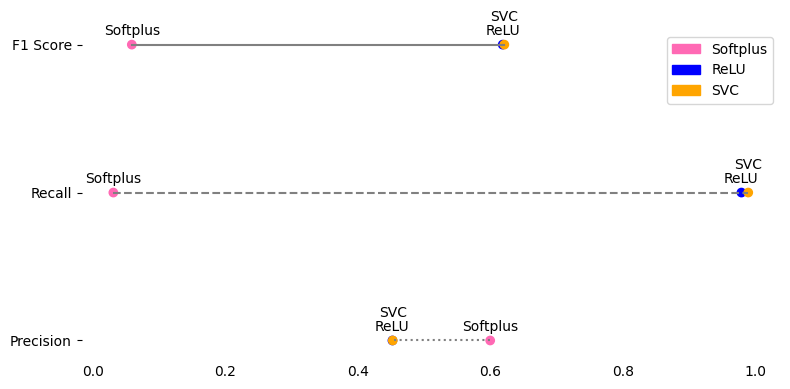

In [162]:
import matplotlib.patches as mpatches

precisions = [softplus_pr, relu_pr, svc_pr]
recalls = [softplus_re, relu_re, svc_re]
f1_scores = [softplus_f1, relu_f1, svc_f1]
labels = ['Softplus', 'ReLU', 'SVC']
colors = ['hotpink', 'blue', 'orange']

fig, ax = plt.subplots(figsize=(8, 4))

ax.scatter(precisions, [0]*len(precisions), color=colors, label='Precision')
ax.scatter(recalls, [1]*len(recalls), color=colors, label='Recall')
ax.scatter(f1_scores, [2]*len(f1_scores), color=colors, label='F1 Score')

ax.plot(precisions, [0]*len(precisions), color='gray', linestyle=':')
ax.plot(recalls, [1]*len(recalls), color='gray', linestyle='--')
ax.plot(f1_scores, [2]*len(f1_scores), color='gray', linestyle='-')

ax.set_yticks([0, 1, 2])
ax.set_yticklabels(['Precision', 'Recall', 'F1 Score'])

for i, label in enumerate(labels):
    if label == 'SVC':
        ax.annotate(label, (precisions[i], 0), textcoords="offset points", xytext=(0,15), ha='center', va='bottom')
        ax.annotate(label, (recalls[i], 1), textcoords="offset points", xytext=(0,15), ha='center', va='bottom')
        ax.annotate(label, (f1_scores[i], 2), textcoords="offset points", xytext=(0,15), ha='center', va='bottom')
    else:
        ax.annotate(label, (precisions[i], 0), textcoords="offset points", xytext=(0,15), ha='center', va='top')
        ax.annotate(label, (recalls[i], 1), textcoords="offset points", xytext=(0,15), ha='center', va='top')
        ax.annotate(label, (f1_scores[i], 2), textcoords="offset points", xytext=(0,15), ha='center', va='top')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(axis='x', which='both', bottom=False)

legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, labels)]
ax.legend(handles=legend_patches)

plt.tight_layout()
plt.show()

# Investigate the fitted weights in the first layer of NN with SVC Loss

In [170]:
Z = X_test.values.dot(relu_W)
z_df = pd.DataFrame(Z, columns=['z1', 'z2', 'z3'])
z_df

,z1,z2,z3
0,6.606465,-10.932213,7.112206
1,7.186146,-8.766397,8.003881
2,6.620414,-8.801445,7.683436
3,9.585954,-10.488411,10.161895
4,7.376667,-9.499037,7.858357
...,...,...,...
208,7.628317,-8.957332,7.276523
209,2.213975,0.745403,2.694405
210,8.464500,-9.902961,8.024564
211,6.920501,-9.146019,7.620380


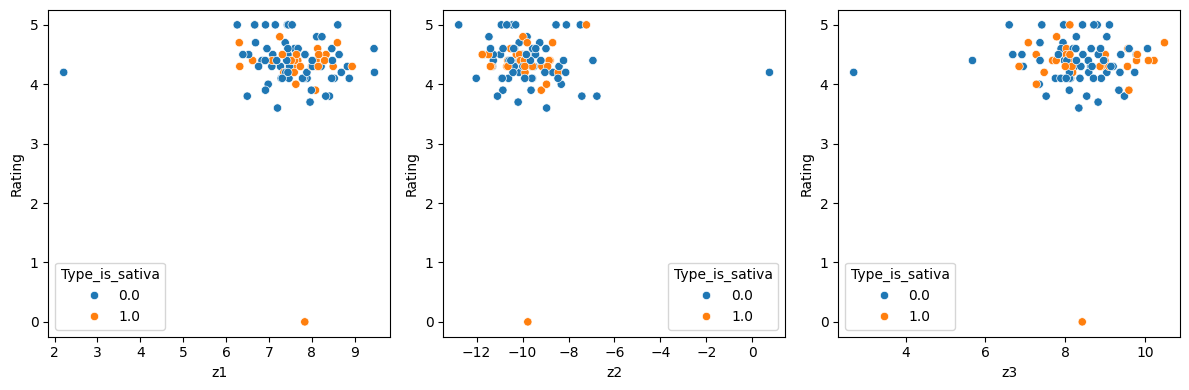

In [174]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

sns.scatterplot(x=z_df['z1'], y=c_df['Rating'], hue=c_df['Type_is_sativa'], ax=axs[0])
axs[0].set_xlabel('z1')
axs[0].set_ylabel('Rating')

sns.scatterplot(x=z_df['z2'], y=c_df['Rating'], hue=c_df['Type_is_sativa'], ax=axs[1])
axs[1].set_xlabel('z2')
axs[1].set_ylabel('Rating')

sns.scatterplot(x=z_df['z3'], y=c_df['Rating'], hue=c_df['Type_is_sativa'], ax=axs[2])
axs[2].set_xlabel('z3')
axs[2].set_ylabel('Rating')

plt.tight_layout()
plt.show()
